In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import numpy as np
from scipy.signal import argrelmax
from scipy.optimize import curve_fit

import math
from itertools import takewhile

### General helper functions

In [2]:
def is_between(data, lower, upper):
    return np.logical_and(data >= lower, data < upper)

def between(data, lower, upper):
    return data[is_between(data, lower, upper)]

#TODO axis, more dimensions
def is_around(data, point, range):
    return is_between(data, point - range, point+range)
    
def around(data, point, range):
    return data[is_around(data, point, range)]

np.is_between = is_between
np.between    = between
np.is_around  = is_around
np.around     = around

In [3]:
def format_exp (number, decimals=2):
    def exp_(f):
        return int(math.floor(math.log10(abs(f)))) if f != 0 else 0
    
    exponent = exp_(number)
    mantissa = number / 10**exponent
    
    return "%%.%if" % decimals % mantissa + "$\\times 10^{%s}$" % exponent

## Loading the gamma table

In [4]:
table = pd.read_csv("build/U_238.txt", delimiter="\t")
table["Norm_prob"] = table["Probability"] / table["Probability"].sum()

### Reading data

In [5]:
def read_file(folder_name = "./", file_name="B4_nt_B4_t%i.csv", num_threads=4, column_names = ["Energy", "Track_length"]):
    file_name = folder_name + file_name
    
    data = pd.read_csv (file_name % 0, comment="#", header=None, names=column_names)
    for i in range(1, num_threads):
        data = data.append(pd.read_csv (file_name % i, comment="#", header=None, names=column_names))
    
    return data

In [6]:
def read_with_angle (dir_name, num_threads=4):
    data_with_angle = read_file(dir_name, column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"], num_threads=num_threads)
    data_with_angle["angle"] = np.arccos(np.dot(data_with_angle[["p_X", "p_Y", "p_Z"]], [0,0,1]))
    return data_with_angle

In [7]:
def read_distance_folders (base_folder_name, dists, num_threads=4):
    datas = []
    
    for dist in dists:
        datas.append(read_with_angle (base_folder_name + "/%i/" % dist, num_threads=num_threads))
    
    return datas

In [8]:
def read_distance_vs_hits(base_folder_name="./distance", dists= list(range(0, 20)) + list(range(20, 100, 5)), num_threads=4):
    hits  = []
    
    for dist in dists:
        data = read_with_angle (base_folder_name + "/%i/" % dist, num_threads=num_threads)
        hits.append((data["Energy"] > data["Energy"].max() * 0.95).sum())
    return dists, hits

### Helper functions

In [9]:
def count_hit_ratio_around_peaks (data, peaks=table, radius = 0.005):
    hits_around_peak = []
    
    for _, (isotope, E, p, p_norm) in peaks.iterrows():
        hits_around_peak.append([E, np.is_around(data, E, radius).sum() / len(data)])
    
    return np.array(hits_around_peak)

In [10]:
def calculate_full_efficiency (data, cutoff = 0):
    return (data > cutoff).sum() / len(data)

In [11]:
def SimpleHistogram(X, name=None, plot_peaks=False, alpha=None, label=None, do_texts=True, bin_num=200):
    vals, bins, _ = plt.hist(X, bin_num, alpha=alpha, label=label);
    
    #ignore 0 and photopeak
    ylim  = vals[1:-1].max() * 1.1
    x_max = X.max()
    
    plt.ylim(0,ylim)
    plt.xlabel("E absorbed [MeV]")
    plt.ylabel("# of events")
    
    if do_texts:
        if bins[0] == 0:
            plt.text(0     + 0.005, ylim * 0.9, "<- %s" % format_exp(vals[0]),  horizontalalignment='left',  fontsize=8)
        
        if vals[-1] > ylim:
            plt.text(x_max - 0.005, ylim * 0.9, "%s ->" % format_exp(vals[-1]), horizontalalignment='right', fontsize=8)
    
    if plot_peaks:
        plot_peaks(bins[:-1], vals, ylim)
    
    if name:
        plt.savefig(name + ".svg")

In [12]:
def plot_peaks(x, y, ylim, diff=100, order=50):
    
    inds = argrelmax(y, order=order)[0]
    
    for ind in inds:
        plt.text(x[ind], min(y[ind], ylim)*0.9, "E = %.2f ->" % x[ind], horizontalalignment="right")

In [13]:
def plot_L_vs_E(data, name=None):
    plt.hist2d(data["Track_length"], data["Energy"], 50, norm=LogNorm());
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor("lightgray")
    colbar = plt.colorbar();
    colbar.set_label("# of events")
    
    plt.xlabel("Track length [m]")
    plt.ylabel("E absorbed [MeV]")
    
    if name:
        plt.savefig(name + ".svg")

# Data analysis

In [48]:
data = read_file(column_names=["Energy", "Track_length", "p_X", "p_Y", "p_Z"])
data

,Energy,Track_length,p_X,p_Y,p_Z
0,1.000000,0.914596,0.000000,0.000000,1.000000
1,0.818028,1.045090,0.409069,-0.005816,-0.912485
2,0.694412,0.916748,0.901940,0.399254,-0.164624
3,0.556754,0.490054,0.627641,0.690259,0.360012
4,0.038119,0.008548,-0.195388,0.044323,0.979724
...,...,...,...,...,...
25419,1.000000,1.111440,0.000000,0.000000,1.000000
25420,0.353213,0.304353,-0.220131,-0.655663,0.722252
25421,0.245891,0.201651,-0.443040,0.383308,0.810426
25422,1.000000,1.007460,0.000000,0.000000,1.000000


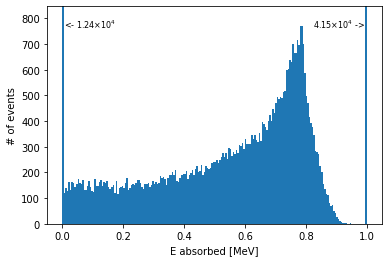

In [10]:
SimpleHistogram(data["Energy"])

(0, 1500)

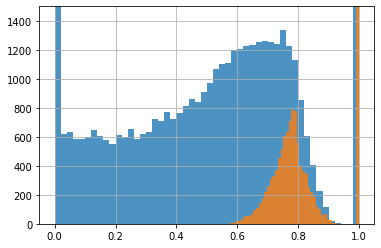

In [133]:
asd = data.groupby(pd.cut(data["Track_length"], [-np.inf, 0.8, np.inf]))
asd["Energy"].hist(stacked=True, alpha=0.8, bins=50)
plt.ylim(0, 1500)

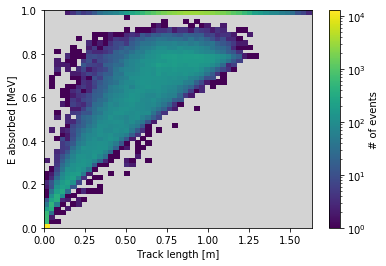

In [135]:
plot_L_vs_E(data)

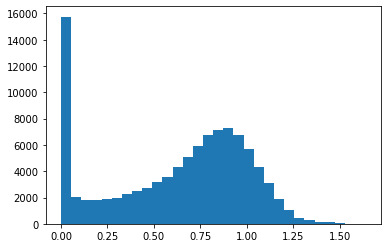

In [136]:
plt.hist(data["Track_length"], bins=30);

In [137]:
from scipy.stats import binned_statistic

avg, edges, _ = binned_statistic(data["Energy"], data["Track_length"], 'mean', bins=50)
x_ = edges[:-1]

/home/balazzs/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Average track length')

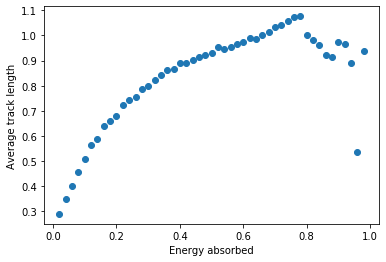

In [138]:
plt.plot(x_, avg/x_, "o")
plt.xlabel("Energy absorbed")
plt.ylabel("Average track length")

# Different physics

#### Penelope vs EmStandard (QBBC)

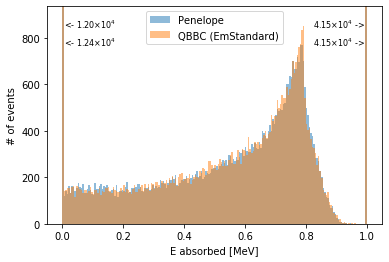

In [234]:
data_penelope = read_file("1MeV_cylinder_penelope/")
data_QBBC     = read_file("1MeV_cylinder_QBBC/")
SimpleHistogram(data_penelope["Energy"], alpha=0.5, label="Penelope")
SimpleHistogram(data_QBBC["Energy"]    , alpha=0.5, label="QBBC (EmStandard)")

plt.legend()

plt.savefig("physics_1MeV.svg")

#### Photoeffect on/off

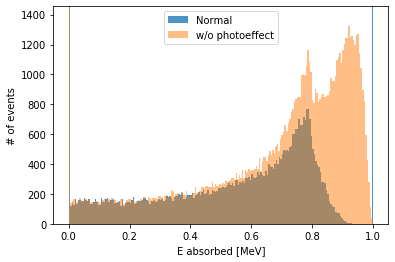

In [275]:
data_no_photo = read_file("1MeV_nophotoeffect_penelope/")
SimpleHistogram(data_penelope["Energy"], do_texts=False, alpha=0.8, label="Normal")
SimpleHistogram(data_no_photo["Energy"], do_texts=False, alpha=0.5, label="w/o photoeffect")
plt.legend();

plt.savefig("photoeffect.svg")

#### Penelope vs Livermore vs EmStandard

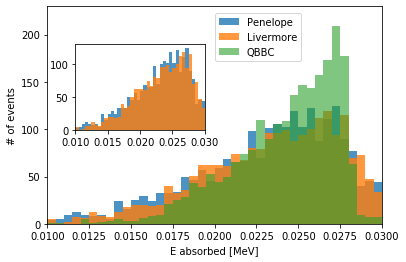

In [272]:
data_penelope_100kev  = read_file("100keV_penelope/")
data_QBBC_100kev      = read_file("100keV_QBBC/")
data_livermore_100kev = read_file("100keV_livermore/")

SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
SimpleHistogram(data_QBBC_100kev["Energy"]     , do_texts=False, alpha=0.6, label="QBBC")

plt.xlim(0.01, 0.03)
plt.legend(loc=(.5, .75))


left, bottom, width, height = [0.19, 0.45, 0.3, 0.3]
ax2 = plt.gcf().add_axes([left, bottom, width, height])
SimpleHistogram(data_penelope_100kev["Energy"] , do_texts=False, alpha=0.8, label="Penelope")
SimpleHistogram(data_livermore_100kev["Energy"], do_texts=False, alpha=0.8, label="Livermore")
plt.xlim(0.01, 0.03)
plt.ylabel("");
plt.xlabel("");

plt.savefig("physics_100keV.svg")

# Exit angle

## Absorbed energy angle dependence

In [67]:
def make_angle_vs_energy_plot (data):
    sub_data = data[np.logical_and(data["Energy"] != data["Energy"].max(), data["Energy"] != 0.0)]
    
    plt.hist2d(sub_data["angle"], sub_data["Energy"], bins=30, norm=LogNorm());
    cbar = plt.colorbar()
    
    plt.xlabel("Exit angle [rad]")
    plt.ylabel("Absorbed energy [MeV]")
    cbar.set_label("# of events")

In [98]:
data_10MeV_angle  = read_with_angle("exit_angle/10MeV/")
data_1MeV_angle   = read_with_angle("exit_angle/1MeV/")
data_511keV_angle = read_with_angle("exit_angle/511keV/")
data_250keV_angle = read_with_angle("exit_angle/250keV/")
data_100keV_angle = read_with_angle("exit_angle/100keV/")

In [297]:
#deposited energy in single Compton scattering (theroetical)
#E:     energy of photon
#theta: scattering angle
def e_dep(E, theta):
    m_e = 511e3
    return E * (1 - 1 / (1 + (E / m_e) * (1 - np.cos(theta))))

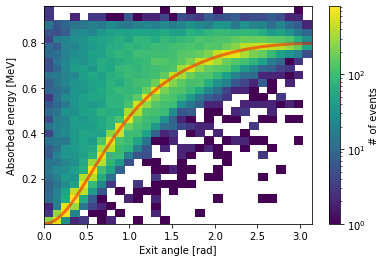

In [313]:
make_angle_vs_energy_plot(data_1MeV_angle)

X = np.linspace(0,3.14, 100)
plt.plot(X, e_dep(1e6, X)/1e6, color="red", alpha=0.5, lw=3)

plt.savefig("exit_angle_distribution.svg")

## Exit direction distribution

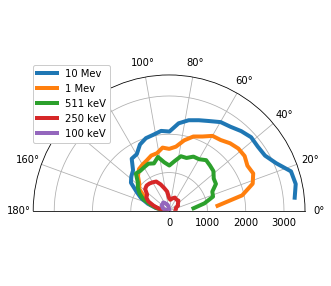

In [316]:
plt.figure(figsize=(5,5))

vals, bins = np.histogram(data_10MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="10 Mev")
vals, bins = np.histogram(data_1MeV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="1 Mev")
vals, bins = np.histogram(data_511keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="511 keV")
vals, bins = np.histogram(data_250keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="250 keV")
vals, bins = np.histogram(data_100keV_angle["angle"], bins=30)
plt.polar(bins[1:-1], vals[1:], lw=4, label="100 keV")

plt.gca().set_thetamax(180)
plt.yticks([0, 1000, 2000, 3000])
plt.legend(loc= (0.0, 0.5), framealpha=1);

plt.savefig("exit_angle_polar.svg", bbox_inches="tight")

# World changed to air from vacuum

# Particla gun -> source

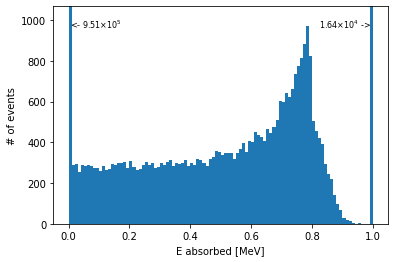

In [254]:
data_source = read_with_angle("distance/5/")
SimpleHistogram(data_source["Energy"], bin_num=100)

basically the same with radial distribution

# Distance

In [268]:
dists, hits = read_distance_vs_hits()

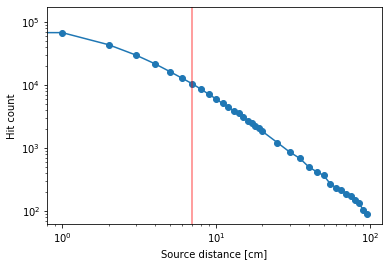

In [290]:
plt.plot(dists, hits, "o-")

detector_size = 7
plt.axvline(detector_size, color="red", alpha=0.5)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Source distance [cm]")
plt.ylabel("Hit count")
plt.savefig("distance_vs_hits.svg")

# Uranium gamma energy distribution

## From table

(probability of given energies given in a table; photons for events generated from the table)

In [173]:
data_U238_table = read_with_angle("data/uranium_table_simple_detector/")

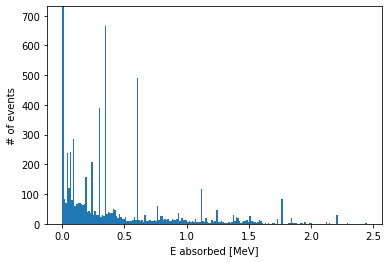

In [9]:
SimpleHistogram(data_U238_table["Energy"], do_texts=False)
plt.savefig("figures/U_238_table_simple_geom.svg", bbox_layout="tight")

In [286]:
#initial energy of photons
primary_energies = np.loadtxt("data/uranium_table_simple_detector/primary_energies.txt")
primary_energies = np.loadtxt("data/data_table_simple_geom_big/primaryEnergies.txt")

#### Generation validation

Mean absolute difference: 0.003%


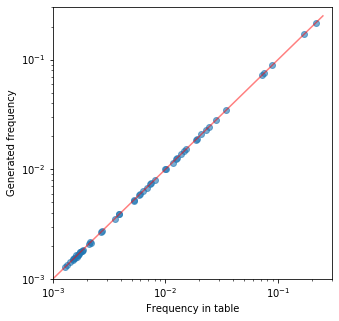

In [595]:
primary_numbers = np.unique(primary_energies, return_counts=True)[1]
primary_freq    = primary_numbers / sum(primary_numbers)

plt.figure(figsize=(5,5))

plt.scatter(table["Norm_prob"], primary_freq, alpha=0.6)
plt.plot([0, 0.25], [0, 0.25], color="red", alpha=0.5)

plt.xlabel("Frequency in table")
plt.ylabel("Generated frequency")

plt.yscale("log")
plt.xscale("log")
plt.ylim(0.001, 0.3)
plt.xlim(0.001, 0.3)

avg_diff = sum(abs(table["Norm_prob"] - primary_freq)) / len(table)
print ("Mean absolute difference: %.3f%%" % (avg_diff * 100))

plt.savefig("figures/table_simple_geom_big_frequency_check.svg", bbox_layout="tight")

## From simulation (RadioactiveDecay)

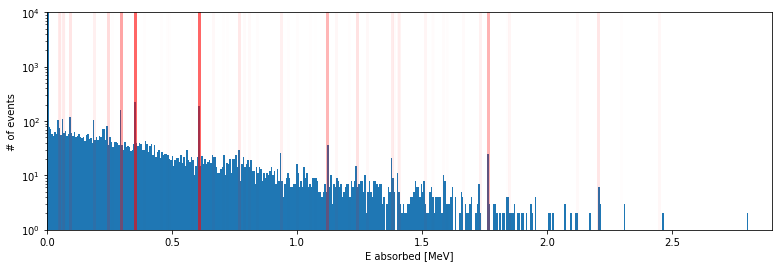

In [257]:
data_U238_decay_simple_geom = read_with_angle("data/decay_U238/")

plt.figure(figsize=(13,4))

for _, (isotope, E, P, P_norm) in table.iterrows():
    plt.axvline(E, color="red", alpha=min(P_norm*4, 0.6), linewidth=3)

SimpleHistogram(data_U238_decay_simple_geom["Energy"], bin_num=500, do_texts=False)
plt.yscale("log")
plt.ylim(1,10000)
plt.xlim(0, 2.9)

plt.savefig("figures/U_238_simdecay_simple_geom.svg", bbox_layout="tight")

# More realistic geometry created

default distance set to 5 cm (from detector, not crystal)

**from now on gamma particles are only generated with momentum towards the detector (on a half-sphere)**

**!!!!!**<br>
**don't forget that now the crystal is positioned at 0.5 cm, so distances are not compatible with previous ones<br>
I have initially forgotten this, these are the corrected results**

## U 238 table

In [449]:
data_table_simple_geom = read_with_angle("data/distance_table_simple_geom/5/", num_threads=8)
data_table_real_geom   = read_with_angle("data/uranium_table_real_geom/")

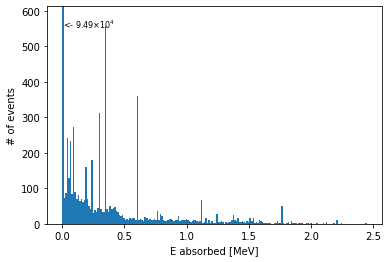

In [280]:
SimpleHistogram(data_table_real_geom["Energy"])
plt.savefig("figures/U_238_table_real_geom.svg", bbox_layout="tight")

#### Realistic vs simple cylinder geom

In [511]:
def plot_geometry_comparison (data_simple, data_real):
    vals_real  , bins_real   = np.histogram(data_real["Energy"]  , bins=200)
    vals_simple, bins_simple = np.histogram(data_simple["Energy"], bins=200)
    
    if not np.all(bins_simple == bins_real):
        print ("Error: Different bins")
        return
    
    #normalize
    vals_real   = vals_real   / vals_real.sum()
    vals_simple = vals_simple / vals_simple.sum()
    
    plt.figure(figsize=(6,5))
    
    plt.scatter(vals_real, vals_simple, c=bins_real[:-1], alpha=0.5)
    
    plt.xlabel("Hits for realistic geometry")
    plt.ylabel("Hits for simple geometry")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(5e-6,1e-2)
    plt.ylim(5e-6,1e-2)
    
    plt.plot([0, 1], [0, 1], color="red")
    cbar = plt.colorbar()
    cbar.set_label("Energy [MeV]")

def plot_geometry_comparison_histo (data_simple, data_real, scale):
    vals_real  , bins_real   = np.histogram(data_real["Energy"]  , bins=200)
    vals_simple, bins_simple = np.histogram(data_simple["Energy"], bins=200)
    
    if not np.all(bins_simple == bins_real):
        print ("Error: Different bins")
        return
    
    #normalize
    vals_real   = vals_real   / vals_real.sum()
    vals_simple = vals_simple / vals_simple.sum()
    
    plt.bar(bins_real[2:-1], (vals_real[1:-1]-vals_simple[1:-1]) * 100 / scale, width=bins_real[2]-bins_real[1])
    
    plt.xlabel("Energy [MeV]")
    plt.ylabel("Difference [%.2e %%]" % scale)

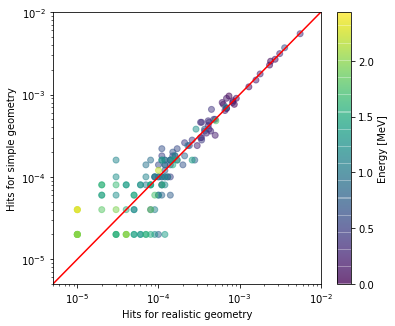

In [392]:
plot_geometry_comparison (data_table_simple_geom, data_table_real_geom)
plt.savefig("figures/table_simple_vs_real_geom_corrected.svg", bbox_layout="tight")

In [452]:
data_table_simple_geom_big = read_with_angle ("data/data_table_simple_geom_big/", num_threads=8)
data_table_real_geom_big   = read_with_angle ("data/data_table_real_geom_big/", num_threads=4)

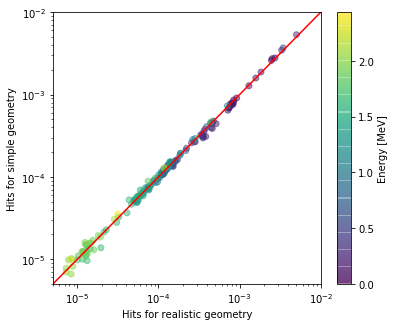

In [393]:
plot_geometry_comparison (data_table_simple_geom_big, data_table_real_geom_big)
plt.savefig("figures/table_simple_vs_real_geom_big.svg", bbox_layout="tight")

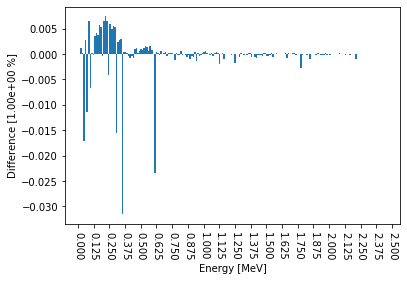

In [552]:
#scale is only valid for about 200 keV after that the next plateau will be smaller than 10000 hits and soon reaches 1000 hits
plot_geometry_comparison_histo (data_table_simple_geom_big, data_table_real_geom_big, 1)#10000/1e7)
plt.xticks(np.linspace(0,2.5, 21), rotation=-90);

plt.savefig("figures/table_simple_vs_real_geom_big_diff_hist.svg", bbox_inches="tight")

## Monoenergetic gamma

In [401]:
data_mono_real_geom = read_with_angle("data/real_geom_monoenergetic_1MeV_5cm/")

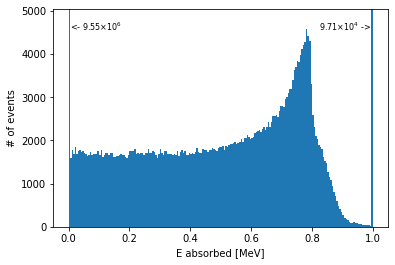

In [433]:
SimpleHistogram(data_mono_real_geom["Energy"])

seems to be not much different...

In [419]:
data_mono_real_geom_500keV   = read_with_angle("data/real_geom_monoenergetic_500keV_5cm/", num_threads=8)
data_mono_simple_geom_500keV = read_with_angle("data/simple_geom_monoenergetic_500keV_5cm/", num_threads=8)

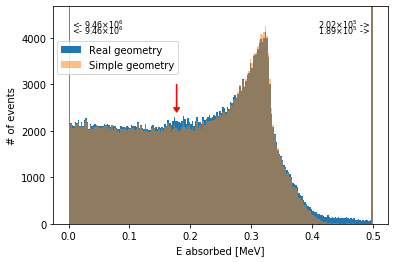

In [581]:
SimpleHistogram (data_mono_real_geom_500keV["Energy"],   label="Real geometry")
SimpleHistogram (data_mono_simple_geom_500keV["Energy"], label="Simple geometry", alpha=0.5)

#get max pos / compton edge pos of simple geom
vals, bins = np.histogram(data_mono_simple_geom_500keV["Energy"], bins=200)
max_pos = bins[np.argmax(vals[1:-1])+1]
#expected backscatter around photopeak - max pos; always ~200keV
exp_pos = 0.5 - max_pos

#draw arrow at expected backscatter peak
plt.arrow(exp_pos, 3000, 0, -500, head_width=0.01, head_length=100, color="red")

plt.legend(loc=(0.01, 0.69))

plt.savefig("figures/mono_simple_vs_real_geom_hists.svg", bbox_inches="tight")

apparently there **is** some difference

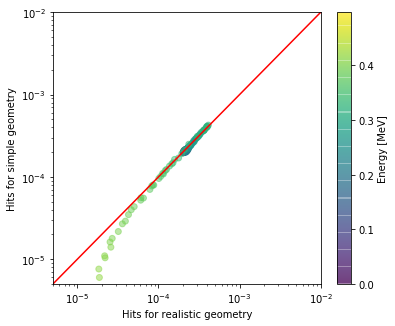

In [554]:
plot_geometry_comparison (data_mono_simple_geom_500keV, data_mono_real_geom_500keV)
plt.savefig("figures/mono_simple_vs_real_geom_500keV.svg", bbox_inches="tight")

## U238 simulated decay

In [27]:
data_simdecay_real_geom = read_with_angle("data/distance_simdecay_real_geom/5/")

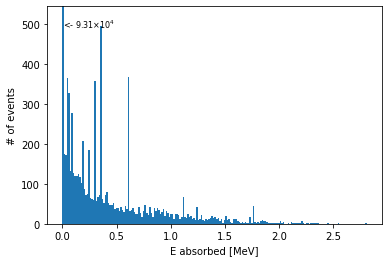

In [22]:
SimpleHistogram(data_simdecay_real_geom["Energy"])

#### RadioactiveDecay vs gamma Table - hits around table peaks

In [360]:
table_hits    = count_hit_ratio_around_peaks(data_table_real_geom["Energy"])
simdecay_hits = count_hit_ratio_around_peaks(data_simdecay_real_geom["Energy"])

In [361]:
ratio = simdecay_hits[:, 1].sum() / table_hits[:, 1].sum()
print ("Ratio of peak hits: %.3f" % ratio)
print ()
print ("Note that table momentums are generated only on a half-sphere while simulated decay is isometric")
print ("Corrigated ratio: %.3f" % (ratio * 2))
print ("Sum probability from table: %.3f" % table["Probability"].sum())

Ratio of peak hits: 1.089

Note that table momentums are generated only on a half-sphere while simulated decay is isometric
Corrigated ratio: 2.177
Sum probability from table: 2.163


Note that the table is not complete. Only contains P(E) > 0.001

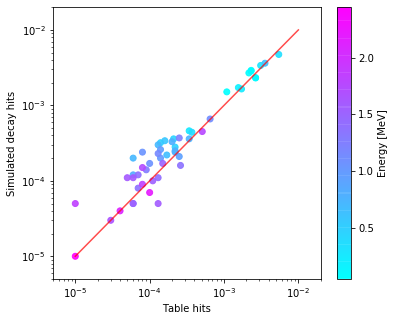

In [396]:
plt.figure(figsize=(6,5))

plt.scatter(table_hits[:, 1], simdecay_hits[:, 1], c=table_hits[:, 0], alpha=.9, cmap="cool")

plt.plot([1e-5, 1e-2], [1e-5, 1e-2], color="red", alpha=0.7)

plt.xscale("log")
plt.xlim(0.000005, 0.02)
plt.yscale("log")
plt.ylim(0.000005, 0.02)

plt.xlabel("Table hits")
plt.ylabel("Simulated decay hits");
cbar = plt.colorbar()
cbar.set_label("Energy [MeV]")

plt.savefig("figures/real_geom_table_vs_simdecay_peak_hits_5cm.svg", bbox_inches="tight")

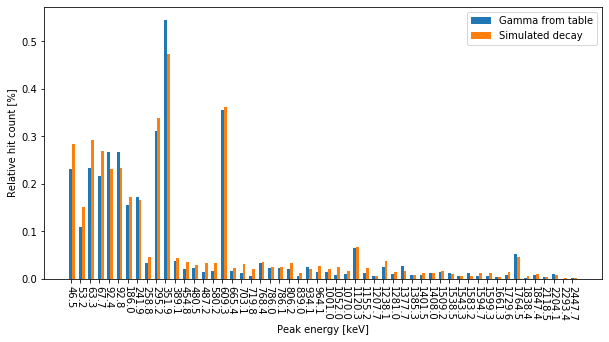

In [591]:
plt.figure(figsize=(10,5))

#x poitions 0-len(table)
Xs     = np.arange(len(table))
#offset of 2nd bar plot
offset = 0.3

plt.bar(Xs,          table_hits[:, 1]    * 100, width=0.3, label="Gamma from table")
plt.bar(Xs+offset,   simdecay_hits[:, 1] * 100, width=0.3, label="Simulated decay")

plt.xticks(rotation=-90)
plt.xticks(Xs, ["%.1f" % E for E in table["E_MeV"] * 1000])

plt.xlabel("Peak energy [keV]")
plt.ylabel("Relative hit count [%]")

plt.legend();

plt.savefig("figures/real_geom_table_vs_simdecay_peak_hits_5cm_bars.svg", bbox_inches="tight")

# Distance, geometry, generation type runs

In [124]:
dist_table_simple_geom    = read_distance_folders("data/distance_table_simple_geom",    dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_simdecay_simple_geom = read_distance_folders("data/distance_simdecay_simple_geom", dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_table_real_geom      = read_distance_folders("data/distance_table_real_geom",      dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=8)
dist_simdecay_real_geom   = read_distance_folders("data/distance_simdecay_real_geom",   dists=list(range(1,10)) + list(range(10, 21, 2)), num_threads=4)

#### Simple vs real geometry in simulated decay

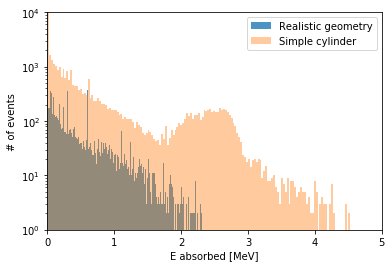

In [398]:
SimpleHistogram(dist_simdecay_real_geom[4]["Energy"],   do_texts=False, label="Realistic geometry", alpha=.8)
SimpleHistogram(dist_simdecay_simple_geom[4]["Energy"], do_texts=False, label="Simple cylinder",    alpha=.4)

plt.legend()

plt.yscale("log")
plt.xlim(0, 5);
plt.ylim(1, 1e4);

plt.savefig("figures/simdecay_simple_vs_real_geom_5cm.svg", bbox_inches="tight")

There are large number of other particles (e.g. $e^-$) in the simulated decay, the Al layer in front of the crystal (the front of the detector) helps a lot blocking these. This is why it is important for this simulation, and why the results differ so much.

#### Table vs simulated decay

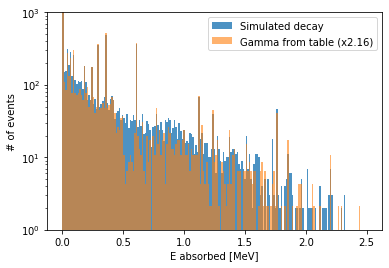

In [355]:
weights = np.ones_like(dist_table_real_geom[4]["Energy"]) * table["Probability"].sum()
bins = np.linspace(0, 2.5, 200)
plt.hist(dist_simdecay_real_geom[4]["Energy"], bins=bins, alpha=0.8, label="Simulated decay");
plt.hist(dist_table_real_geom[4]["Energy"]   , bins=bins, alpha=0.6, label="Gamma from table (x2.16)", weights=weights);

plt.xlabel("E absorbed [MeV]")
plt.ylabel("# of events")

plt.legend()

plt.yscale("log")
plt.ylim(1, 1e3);

plt.savefig("figures/real_geom_table_vs_simdecay_5cm.svg", bbox_inches="tight")

Many common peaks. somewhat different distribution.

# Photopeak and total efficiency

In [52]:
mono_energies = list(range(100,1000+1, 100))
mono_real_geom_5cm__energy_1 = read_distance_folders("data/mono_real_geom__energy_1/", dists=mono_energies, num_threads=8)
mono_real_geom_5cm__energy_2 = read_distance_folders("data/mono_real_geom__energy_2/", dists=mono_energies, num_threads=8)
mono_real_geom_5cm__energy_3 = read_distance_folders("data/mono_real_geom__energy_3/", dists=mono_energies, num_threads=8)

mono_datas = [mono_real_geom_5cm__energy_1, mono_real_geom_5cm__energy_2, mono_real_geom_5cm__energy_3]

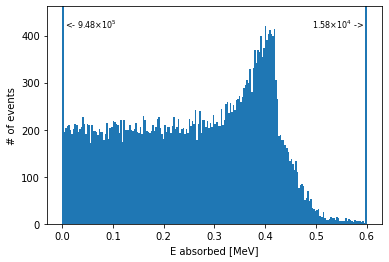

In [53]:
SimpleHistogram(mono_datas[0][5]["Energy"])

#### Photopeak and full efficiency for each 3 reruns at each energy

In [69]:
def get_efficiencies_of_mono_energies (mono_energies, mono_datas):
    photo_efficiencies = []
    full_efficiencies  = []
    
    for mono_run_set in mono_datas:
        photo = []
        full  = []
        for energy, data in zip(mono_energies, mono_run_set):
            mono_peak        = pd.DataFrame({"E_MeV" : [energy/1000]}, columns=table.columns)
            hits_on_peak     = count_hit_ratio_around_peaks(data["Energy"], peaks=mono_peak)[0][1]
            photo_efficiency = hits_on_peak / 2                       #Half sphere angular distr.
            full_efficiency  = calculate_full_efficiency(data)[0] / 2 #Half sphere angular distr.
            
            photo.append(photo_efficiency)
            full.append(full_efficiency)
        
        photo_efficiencies.append(photo)
        full_efficiencies.append(full)
    
    return np.array(photo_efficiencies), np.array(full_efficiencies)

In [70]:
photo_efficiencies, full_efficiencies = get_efficiencies_of_mono_energies(mono_energies, mono_datas)

Y errors:
[2.57500000e-04 1.13166667e-04 6.90000000e-05 1.24500000e-04
 8.50000000e-06 3.70000000e-05 9.63333333e-05 2.10000000e-05
 2.41666667e-05 4.70000000e-05]


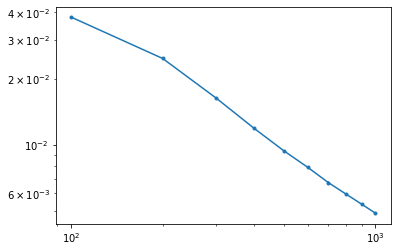

In [71]:
dy_max = np.abs(photo_efficiencies - photo_efficiencies.mean(axis=0)).max(axis=0)
print("Y errors:")
print(dy_max)

plt.yscale("log")
plt.xscale("log")

plt.errorbar(mono_energies, photo_efficiencies.mean(axis=0), dy_max, fmt=".-");

The errors are basically invisible

#### Fitting the power laws

In [72]:
lin_photo, _ = curve_fit(lambda x, a, b: x * a + b, np.log10(mono_energies[1:]), np.log10(photo_efficiencies.mean(axis=0)[1:]))
lin_full,  _ = curve_fit(lambda x, a, b: x * a + b, np.log10(mono_energies[1:]), np.log10(full_efficiencies.mean(axis=0)[1:]))

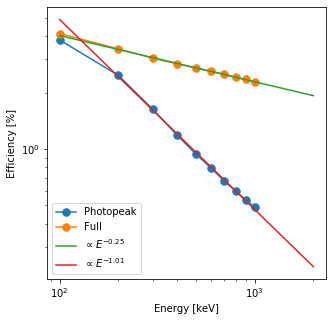

In [75]:
plt.figure(figsize=(5,5))

plt.plot(mono_energies, photo_efficiencies.mean(axis=0) * 100, ".-", markersize=15, label="Photopeak")
plt.plot(mono_energies, full_efficiencies.mean(axis=0)  * 100, ".-", markersize=15, label="Full")

X = np.linspace(100, 2000, 100)
plt.plot(X, 100 * 10 ** (np.log10(X) * lin_full [0] + lin_full[1] ), label="$\\propto E^{%.2f}$" % (lin_full [0]))
plt.plot(X, 100 * 10 ** (np.log10(X) * lin_photo[0] + lin_photo[1]), label="$\\propto E^{%.2f}$" % (lin_photo[0]))

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Energy [keV]")
plt.ylabel("Efficiency [%]")

plt.legend();

plt.savefig("figures/mono_E_efficiencies.svg", bbox_inches='tight')

## 2

In [60]:
mono_energies_2 = [25, 60, 100, 150, 250, 600, 1000, 1500, 2500, 6000, 10000, 15000]
mono_real_geom_5cm__energy_4 = read_distance_folders("data/mono_real_geom__energy_4/", dists=mono_energies_2, num_threads=8)
mono_real_geom_5cm__energy_5 = read_distance_folders("data/mono_real_geom__energy_5/", dists=mono_energies_2, num_threads=8)
mono_real_geom_5cm__energy_6 = read_distance_folders("data/mono_real_geom__energy_6/", dists=mono_energies_2, num_threads=8)

mono_datas_2 = [mono_real_geom_5cm__energy_4, mono_real_geom_5cm__energy_5, mono_real_geom_5cm__energy_6]

In [67]:
photo_efficiencies_2, full_efficiencies_2 = get_efficiencies_of_mono_energies(mono_energies_2, mono_datas_2)

Y errors:
[1.16666667e-04 2.07000000e-04 1.99500000e-04 1.39000000e-04
 7.20000000e-05 5.23333333e-05 4.78333333e-05 1.71666667e-05
 4.05000000e-05 2.23333333e-05 1.18333333e-05 9.83333333e-06]


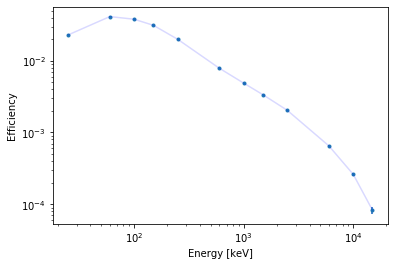

In [74]:
dy_max = np.abs(photo_efficiencies_2 - photo_efficiencies_2.mean(axis=0)).max(axis=0)
print("Y errors:")
print(dy_max)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Energy [keV]")
plt.ylabel("Efficiency")

plt.errorbar(mono_energies_2, photo_efficiencies_2.mean(axis=0), dy_max, fmt=".");
plt.errorbar(mono_energies_2, photo_efficiencies_2.mean(axis=0), dy_max, fmt="-", alpha=0.15, color="blue");

plt.savefig("figures/mono_E_efficiencies_2.svg", bbox_inches="tight")